<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision
Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.
The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza 🍕 & steak 🥩) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb




In [1]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the download file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2021-05-09 09:36:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M   228MB/s    in 0.5s    

2021-05-09 09:36:22 (228 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspect the data (Become one with it)

In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'pizza_steak'.
There are 2 directories and 1 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 2 directories and 1 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.


In [3]:
!ls pizza_steak

test  train


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['.DS_Store' 'pizza' 'steak']


In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
    # Setup target directory (we'llview images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")  # Show the shape of the image

    return img

Image shape: (512, 512, 3)


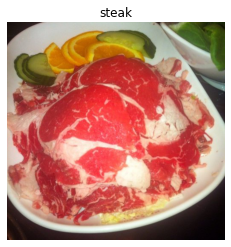

In [7]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [8]:
# The images we've imported and plotted are actually giant arrays/tensors of different pixel values
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[19, 11,  9],
        [21, 13, 11],
        [22, 14, 12],
        ...,
        [19, 36,  2],
        [19, 36,  2],
        [21, 38,  2]],

       [[20, 12, 10],
        [22, 14, 12],
        [23, 15, 13],
        ...,
        [19, 36,  2],
        [18, 35,  1],
        [19, 36,  2]],

       [[21, 13, 11],
        [22, 14, 12],
        [24, 16, 14],
        ...,
        [20, 35,  2],
        [19, 34,  1],
        [19, 34,  1]],

       ...,

       [[29, 10, 12],
        [31, 11, 12],
        [34, 10,  8],
        ...,
        [ 1,  1,  3],
        [ 1,  1,  3],
        [ 1,  1,  3]],

       [[27, 11, 14],
        [29, 11, 11],
        [32, 11, 10],
        ...,
        [ 2,  2,  4],
        [ 1,  1,  3],
        [ 1,  1,  3]],

       [[25, 10, 13],
        [26, 10, 11],
        [32, 11, 10],
        ...,
        [ 2,  1,  6],
        [ 1,  0,  5],
        [ 1,  0,  5]]], dtype=uint8)>

In [9]:
# View the image shape
img.shape       # return (width,height, color channels)

(512, 512, 3)

In [10]:
# Get all the pixel values between 0 & 1
img/255.

array([[[0.0745098 , 0.04313725, 0.03529412],
        [0.08235294, 0.05098039, 0.04313725],
        [0.08627451, 0.05490196, 0.04705882],
        ...,
        [0.0745098 , 0.14117647, 0.00784314],
        [0.0745098 , 0.14117647, 0.00784314],
        [0.08235294, 0.14901961, 0.00784314]],

       [[0.07843137, 0.04705882, 0.03921569],
        [0.08627451, 0.05490196, 0.04705882],
        [0.09019608, 0.05882353, 0.05098039],
        ...,
        [0.0745098 , 0.14117647, 0.00784314],
        [0.07058824, 0.1372549 , 0.00392157],
        [0.0745098 , 0.14117647, 0.00784314]],

       [[0.08235294, 0.05098039, 0.04313725],
        [0.08627451, 0.05490196, 0.04705882],
        [0.09411765, 0.0627451 , 0.05490196],
        ...,
        [0.07843137, 0.1372549 , 0.00784314],
        [0.0745098 , 0.13333333, 0.00392157],
        [0.0745098 , 0.13333333, 0.00392157]],

       ...,

       [[0.11372549, 0.03921569, 0.04705882],
        [0.12156863, 0.04313725, 0.04705882],
        [0.13333333, 0

## An end-to-end example
Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 43s 217ms/step - loss: 0.6293 - accuracy: 0.6408 - val_loss: 0.3987 - val_accuracy: 0.8160
Epoch 2/5
47/47 [==============================] - 9s 202ms/step - loss: 0.4053 - accuracy: 0.8123 - val_loss: 0.3429 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 9s 202ms/step - loss: 0.3540 - accuracy: 0.8487 - val_loss: 0.3670 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 9s 200ms/step - loss: 0.3532 - accuracy: 0.8520 - val_loss: 0.3063 - val_accuracy: 0.8880
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.2994 - accuracy: 0.8868 - val_loss: 0.2788 - val_accuracy: 0.8760


In [12]:
# Get a model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

## Using the same model as before

Let's replicate the model we've built in the previous section to see if it works with our image data

In [13]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                         
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 181ms/step - loss: 3.1761 - accuracy: 0.5075 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 8s 175ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 8s 175ms/step - loss: 0.6934 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 8s 175ms/step - loss: 0.6926 - accuracy: 0.5237 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 8s 172ms/step - loss: 0.6928 - accuracy: 0.5155 - val_loss: 0.6932 - val_accuracy: 0.5000


In [14]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20x more parameters than our CNN model(model_1), model_2 performs terribly, let's try to improve it.

In [15]:
# Set the random seed
tf.random.set_seed(42)

# Create the model (same as above but let's step it up a notch)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                            
])

# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 180ms/step - loss: 8.3766 - accuracy: 0.5518 - val_loss: 1.6600 - val_accuracy: 0.7360
Epoch 2/5
47/47 [==============================] - 8s 172ms/step - loss: 1.6119 - accuracy: 0.7200 - val_loss: 0.5042 - val_accuracy: 0.7780
Epoch 3/5
47/47 [==============================] - 8s 174ms/step - loss: 0.6214 - accuracy: 0.7414 - val_loss: 0.7889 - val_accuracy: 0.6020
Epoch 4/5
47/47 [==============================] - 8s 175ms/step - loss: 0.5038 - accuracy: 0.7781 - val_loss: 0.4319 - val_accuracy: 0.8000
Epoch 5/5
47/47 [==============================] - 8s 177ms/step - loss: 0.5422 - accuracy: 0.7900 - val_loss: 1.1627 - val_accuracy: 0.5540


In [16]:
# Check the model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


My gosh, the number of trainable parameters has increased even more than model_2. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, model_3 still doesn't out perform model_1.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## **Binary Classification: Let's break it down**

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scaling/normalizing & turning our data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

### **1. Become one with the data**

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


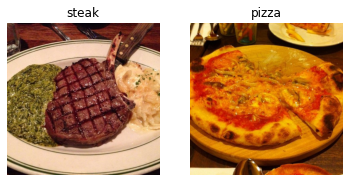

In [17]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### **2. Preprocess the data (prepare it for a model)**

In [18]:
# Define directory dataset paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into batches.

A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:

10,000 images (or more) might not fit into the memory of your processor (GPU).
Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

In [19]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [20]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # Target directoy of images
                                               target_size=(224, 224), # Target size of images (height, width)
                                               class_mode="binary", # type of data you're working with
                                               batch_size=32) # size of minibatches to load data into

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [21]:
# Get a sample of a train data batch
images, labels = train_data.next() # get the "next" batch of images/labels in train_data
len(images), len(labels)

(32, 32)

In [22]:
# How many batches are there ?
len(train_data)

47

In [23]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

In [24]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)

In [25]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [26]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

Let's discuss some of the components of the Conv2D layer:

* The "2D" means our inputs are two
dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* filters - these are the number of "feature extractors" that will be moving over our images.
* kernel_size - the size of our filters, for example, a kernel_size of (3, 3) (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* stride - the number of pixels a filter will move across as it covers the image. A stride of 1 means the filter moves across each pixel 1 by 1. A stride of 2 means it moves 2 pixels at a time.
* padding - this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as 'valid' (default) cuts off excess pixels where the filter doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

In [27]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [28]:
# Get a summary of our model
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 4. Fit the model

In [29]:
# Check the lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

You'll notice two new parameters here:

* steps_per_epoch - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)
* validation_steps - same as above, except for the validation_data parameter (500 test images in batches of 32 = 500/32 = ~16 steps)


In [30]:
# Fit the model
history_4 = model_4.fit(train_data, # this is a combination of labels and sample data
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 194ms/step - loss: 3.3485 - accuracy: 0.5198 - val_loss: 0.5425 - val_accuracy: 0.7660
Epoch 2/5
47/47 [==============================] - 9s 191ms/step - loss: 0.5276 - accuracy: 0.7781 - val_loss: 0.3660 - val_accuracy: 0.8560
Epoch 3/5
47/47 [==============================] - 9s 190ms/step - loss: 0.3966 - accuracy: 0.8402 - val_loss: 0.3484 - val_accuracy: 0.8680
Epoch 4/5
47/47 [==============================] - 9s 190ms/step - loss: 0.3256 - accuracy: 0.8577 - val_loss: 0.3567 - val_accuracy: 0.8460
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.2237 - accuracy: 0.9127 - val_loss: 0.3480 - val_accuracy: 0.8580


### 5. Evaluating our model

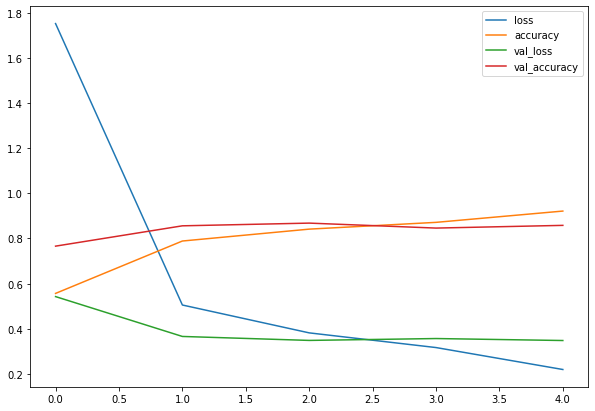

In [31]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [34]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

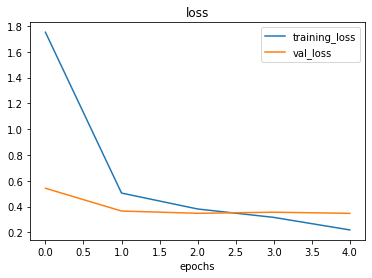

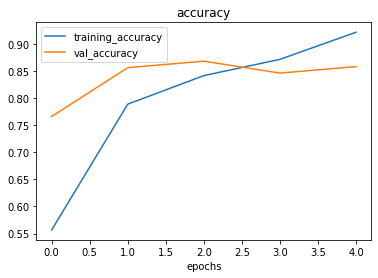

In [35]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

### Adjust the model parameters
Fitting a machine learning model comes in 3 steps:
1. Create a baseline
2. Beat the baseline by overfitting a larger model
3. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

In [44]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

Woah, we've got another layer type we haven't seen before.

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the most important of those features. We'll see this an example of this in a moment.

In [45]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [49]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 9s 187ms/step - loss: 0.3964 - accuracy: 0.8320 - val_loss: 0.3457 - val_accuracy: 0.8440
Epoch 2/5
47/47 [==============================] - 8s 181ms/step - loss: 0.3615 - accuracy: 0.8373 - val_loss: 0.3093 - val_accuracy: 0.8620
Epoch 3/5
47/47 [==============================] - 9s 183ms/step - loss: 0.3424 - accuracy: 0.8580 - val_loss: 0.3162 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 9s 182ms/step - loss: 0.3234 - accuracy: 0.8640 - val_loss: 0.3133 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 8s 180ms/step - loss: 0.3103 - accuracy: 0.8740 - val_loss: 0.3022 - val_accuracy: 0.8600


In [50]:
# Get a summary of our model with max pooling
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6760)             

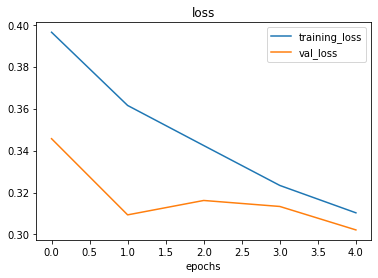

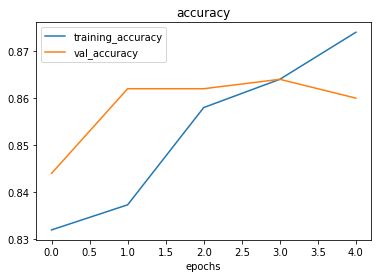

In [51]:
# Plot loss curves
plot_loss_curves(history_5)

### Data Augmentation

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns. Altering might mean adjuting the rotation of an image, flipping it, cropping it or something similar.

In [52]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # how much do you want to rotate an image?
                                             shear_range=0.2, # how much do you want to shear an image?
                                             zoom_range=0.2, # zoom in randomly on an image
                                             width_shift_range=0.2, # move your iamge around on the x-axis
                                             height_shift_range=0.2, # move your image around on the y-axis
                                             horizontal_flip=True) # do you want to flip and image? 

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)

In [53]:
# Import data and augment it from training directory
print("Augmented training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="binary",
                                                                   shuffle=False) # for demonstration purposes only

# Create non-augmented train data batches
print("Non-augmented training data:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="binary",
                                               shuffle=False)

IMG_SIZE = (224, 224)
# Create non-augmented test data batches
print("Non-augmented test data:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode="binary")

Augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented test data:
Found 500 images belonging to 2 classes.


In [54]:
# Get sample data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # note: labels aren't augmented... only data (images)

showing image number: 17


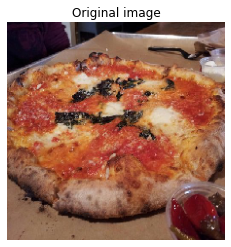

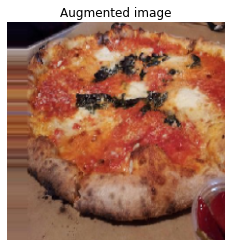

In [58]:
# Show original image and augmented image
import random
random_number = random.randint(0, 32) # our batch sizes are 32...
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);